# Moive Recommendation System based on Spark

## Outline

***Aim***:

        using an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies

***Data Source***:
        
        MovieLens Latest Datasets, [https://grouplens.org/datasets/movielens/latest/]

***Data Schema***:
        
        table movies: {movieId, title, genres}
        table ratings: {userId, movieId, rating, timestamp}
        table tags: {userId, movieId, tag, timestamp}
        table links: {movieId, imdbId, tmdbId}

***Conclusion***:
        
        Here, I tried two Spark Machine Learning libraries, 
        one is Spark MLlib based on RDD, the other is Spark ML based on Dataframe.
        Obviously, the former is faster than the latter, but more complex.
        After using elbow algorthim,  choose the best iteration get the final RMSE  0.887

## Content
        
        Part0: Data ETL and Data Exploration
        Part1: OLAP with Spark
        Part2: Spark ALS based approach for training mode
                  1. grid search
                  2. elbow algorithm
        Part3: Model testing on the test data

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Part 0: Data ETL and Data Exploration

In [7]:
import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [8]:
sc.version

Out[ 4 ]: '2.4.0'

In [9]:
movies = spark.read.load("/FileStore/tables/hw2/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/hw2/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/hw2/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/hw2/tags.csv", format='csv', header = True)

In [10]:
movies.show(5)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
 4|Waiting to Exhale...|Comedy|Drama|Romance|
 5|Father of the Bri...| Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

In [11]:
ratings.show(5)

+------+-------+------+---------+
userId|movieId|rating|timestamp|
+------+-------+------+---------+
 1| 1| 4.0|964982703|
 1| 3| 4.0|964981247|
 1| 6| 4.0|964982224|
 1| 47| 5.0|964983815|
 1| 50| 5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows

In [12]:
tags.show(5)

+------+-------+---------------+----------+
userId|movieId| tag| timestamp|
+------+-------+---------------+----------+
 2| 60756| funny|1445714994|
 2| 60756|Highly quotable|1445714996|
 2| 60756| will ferrell|1445714992|
 2| 89774| Boxing story|1445715207|
 2| 89774| MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows

In [13]:
links.show(5)

+-------+-------+------+
movieId| imdbId|tmdbId|
+-------+-------+------+
 1|0114709| 862|
 2|0113497| 8844|
 3|0113228| 15602|
 4|0114885| 31357|
 5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows

In [14]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1

In [15]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user

## Part 1: OLAP with Spark

### 1: The number of Users

In [18]:
res1 = ratings.select("userId").distinct().count()
print('The number of user is {}'.format(res1))

The number of user is 610

### 2: The number of Movies

In [20]:
res2 = movies.select("movieId").distinct().count()
print('The number of movies is {}'.format(res2))

The number of movies is 9742

### 3:  How many movies are rated by users? List movies not rated before

In [22]:
# how many movies are rated by user
res31 = ratings.select("movieId").distinct().count()
print('There are {} movies are rated by users'.format(res31))

# list not rated before
res32 = movies.select("movieId").distinct().subtract(ratings.select("movieId").distinct()).count()
print('There are {} movies are not rated by users'.format(res32))

There are 9724 movies are rated by users
There are 18 movies are not rated by users

### 4: List Movie Genres

In [24]:
df = movies.toPandas()['genres'].str.get_dummies(sep='|')
print("Movie genres are shown as follows: ")
print([column for column in df])
print("The number of movie genres is {}".format(len([_ for _ in df])-1))

Movie genres are shown as follows: 
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
The number of movie genres is 19

### 5: Movie for Each Category

In [26]:
from pyspark.sql.functions import col, when

df = movies.withColumn('Action', when(col('genres').rlike("Action"), 1).otherwise(0))\
           .withColumn('Adventure', when(col('genres').rlike('Adventure'), 1).otherwise(0)) \
           .withColumn('Animation', when(col('genres').rlike('Animation'), 1).otherwise(0)) \
           .withColumn('Children', when(col('genres').rlike('Children'), 1).otherwise(0)) \
           .withColumn('Comedy', when(col('genres').rlike('Comedy'), 1).otherwise(0)) \
           .withColumn('Crime', when(col('genres').rlike('Crime'), 1).otherwise(0)) \
           .withColumn('Documentary', when(col('genres').rlike('Documentary'), 1).otherwise(0)) \
           .withColumn('Drama', when(col('genres').rlike('Drama'), 1).otherwise(0)) \
           .withColumn('Fantasy', when(col('genres').rlike('Fantasy'), 1).otherwise(0)) \
           .withColumn('Film-Noir', when(col('genres').rlike('Film-Noir'), 1).otherwise(0)) \
           .withColumn('Horror', when(col('genres').rlike('Horror'), 1).otherwise(0)) \
           .withColumn('IMAX', when(col('genres').rlike('IMAX'), 1).otherwise(0)) \
           .withColumn('Musical', when(col('genres').rlike('Musical'), 1).otherwise(0)) \
           .withColumn('Mystery', when(col('genres').rlike('Mystery'), 1).otherwise(0)) \
           .withColumn('Romance', when(col('genres').rlike('Romance'), 1).otherwise(0)) \
           .withColumn('Sci-Fi', when(col('genres').rlike('Sci-Fi'), 1).otherwise(0)) \
           .withColumn('Thriller', when(col('genres').rlike('Thriller'), 1).otherwise(0)) \
           .withColumn('War', when(col('genres').rlike('War'), 1).otherwise(0)) \
           .withColumn('Western', when(col('genres').rlike('Western'), 1).otherwise(0))
display(df.take(10))

movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II (1995),Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Heat (1995),Action|Crime|Thriller,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
7,Sabrina (1995),Comedy|Romance,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,Tom and Huck (1995),Adventure|Children,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Sudden Death (1995),Action,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,GoldenEye (1995),Action|Adventure|Thriller,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

column_names = df.columns[3:]
for genre in column_names:
  print("Category of {} has the number of {} movies".format(genre, df.select(F.sum(genre)).collect()[0][0]))

Category of Action has the number of 1828 movies
Category of Adventure has the number of 1263 movies
Category of Animation has the number of 611 movies
Category of Children has the number of 664 movies
Category of Comedy has the number of 3756 movies
Category of Crime has the number of 1199 movies
Category of Documentary has the number of 440 movies
Category of Drama has the number of 4361 movies
Category of Fantasy has the number of 779 movies
Category of Film-Noir has the number of 87 movies
Category of Horror has the number of 978 movies
Category of IMAX has the number of 158 movies
Category of Musical has the number of 334 movies
Category of Mystery has the number of 573 movies
Category of Romance has the number of 1596 movies
Category of Sci-Fi has the number of 980 movies
Category of Thriller has the number of 1894 movies
Category of War has the number of 382 movies
Category of Western has the number of 167 movies

## Part 2: Spark ALS based approach for training model

**Here, I not only use Spark MLlib based on RDD, but also Spark ML based on Dataframe, it's obviously RDD is more faster than Dataframe but more complex.**

### Spark MLlib

In [30]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

In [31]:
movie_rating = sc.textFile("/FileStore/tables/hw2/ratings.csv")

In [32]:
header = movie_rating.take(1)[0]
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: Rating(tokens[0],tokens[1],tokens[2])).cache()

In [33]:
# check three rows
rating_data.take(3)

Out[ 21 ]: 
[Rating(user=1, product=1, rating=4.0),
 Rating(user=1, product=3, rating=4.0),
 Rating(user=1, product=6, rating=4.0)]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [35]:
train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)
train.cache()
validation.cache()
test.cache()

Out[ 22 ]: PythonRDD[23346] at RDD at PythonRDD.scala:56

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

#### Method 1: Spark Mllib Rdd

In [38]:
import math

def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
  min_error = float('inf')
  best_rank = -1
  best_regularization = 0
  best_model = None
  for rank in ranks:
    for reg in reg_param:
      # write your approach to train ALS model
      model = ALS.train(ratings=train_data, rank=rank, iterations=num_iters, lambda_=reg)
      # make prediction
      predictions = model.predictAll(validation_data.map(lambda r: (r[0], r[1]))).map(lambda r: ((r[0], r[1]), r[2]))
      # get the RMSE
      ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
      ## error = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
      ## ratesAndPreds = predictions.map(lambda x: ((x[0], x[1]), x[2])).join(validation_data.map(lambda x:((x[0], x[1]), x[2]))).values()
      error = math.sqrt(ratesAndPreds.map(lambda x: (x[1][0] - x[1][1]) ** 2).reduce(lambda x,y:x+y) / float(ratesAndPreds.count()))
      # get the rating result
      print('{} latent factores and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
      if error < min_error:
        min_error = error
        best_rank = rank
        best_regularization = reg
        best_model = model
  print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
  return best_model

In [39]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
#start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)
#print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factores and regularization = 0.05: validation RMSE is 0.978614042080799
6 latent factores and regularization = 0.1: validation RMSE is 0.9163477216901559
6 latent factores and regularization = 0.2: validation RMSE is 0.896976432882939
6 latent factores and regularization = 0.4: validation RMSE is 0.9666193007205979
6 latent factores and regularization = 0.8: validation RMSE is 1.1894082482983377
8 latent factores and regularization = 0.05: validation RMSE is 0.9901223353510681
8 latent factores and regularization = 0.1: validation RMSE is 0.9116420253299162
8 latent factores and regularization = 0.2: validation RMSE is 0.8952419168906478
8 latent factores and regularization = 0.4: validation RMSE is 0.9672918785521688
8 latent factores and regularization = 0.8: validation RMSE is 1.1894121295695275
10 latent factores and regularization = 0.05: validation RMSE is 0.9922093721877461
10 latent factores and regularization = 0.1: validation RMSE is 0.9117874609635502
10 latent factores and regularization = 0.2: validation RMSE is 0.8948212056766648
10 latent factores and regularization = 0.4: validation RMSE is 0.9663437402386293
10 latent factores and regularization = 0.8: validation RMSE is 1.1894060373178377
12 latent factores and regularization = 0.05: validation RMSE is 1.000534250205965
12 latent factores and regularization = 0.1: validation RMSE is 0.9184491182351164
12 latent factores and regularization = 0.2: validation RMSE is 0.8958887121577168
12 latent factores and regularization = 0.4: validation RMSE is 0.9664975404647586
12 latent factores and regularization = 0.8: validation RMSE is 1.1894112432585036
14 latent factores and regularization = 0.05: validation RMSE is 0.9987633345441804
14 latent factores and regularization = 0.1: validation RMSE is 0.9140540368818949
14 latent factores and regularization = 0.2: validation RMSE is 0.8968033078718389
14 latent factores and regularization = 0.4: validation RMSE is 0.9668441446776129
14 latent factores and regularization = 0.8: validation RMSE is 1.1894098647133164

The best model has 10 latent factors and regularization = 0.2

#### Method 2: Spark ML Dataframe

In [41]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

train, validation, test = rating_data.randomSplit([6,2,2],seed = 7856)

from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, DoubleType

schema = StructType([ StructField("userId", IntegerType(), True),
                      StructField("movieId", IntegerType(), True),
                      StructField("rating", DoubleType(), True),
                    ])
train, validation, test = spark.createDataFrame(train, schema), spark.createDataFrame(validation, schema), spark.createDataFrame(test, schema)

def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # write your approach to train ALS model
            als = ALS(rank=rank, maxIter=num_iters, regParam=reg, seed=42, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
            # make prediction
            model = als.fit(train_data)
            # get the RMSE
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
            error = evaluator.evaluate(predictions)
            # get the rating result
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [42]:
num_iterations = 10
ranks = [6, 8, 10, 12, 14]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]

import time
#start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)
#print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9883467426223056
6 latent factors and regularization = 0.1: validation RMSE is 0.9221424316410036
6 latent factors and regularization = 0.2: validation RMSE is 0.8996719685769136
6 latent factors and regularization = 0.4: validation RMSE is 0.9677410260860809
6 latent factors and regularization = 0.8: validation RMSE is 1.1894038703543899
8 latent factors and regularization = 0.05: validation RMSE is 0.9851015430496428
8 latent factors and regularization = 0.1: validation RMSE is 0.9153588023305145
8 latent factors and regularization = 0.2: validation RMSE is 0.8964750038475685
8 latent factors and regularization = 0.4: validation RMSE is 0.9666159062472061
8 latent factors and regularization = 0.8: validation RMSE is 1.1894060455111293
10 latent factors and regularization = 0.05: validation RMSE is 0.997408974008884
10 latent factors and regularization = 0.1: validation RMSE is 0.9174163632892535
10 latent factors and regularization = 0.2: validation RMSE is 0.8957017179586898
10 latent factors and regularization = 0.4: validation RMSE is 0.9667137354495521
10 latent factors and regularization = 0.8: validation RMSE is 1.1894081543752384
12 latent factors and regularization = 0.05: validation RMSE is 1.0027634511228782
12 latent factors and regularization = 0.1: validation RMSE is 0.9145472743766029
12 latent factors and regularization = 0.2: validation RMSE is 0.8965903947019012
12 latent factors and regularization = 0.4: validation RMSE is 0.966955784051753
12 latent factors and regularization = 0.8: validation RMSE is 1.1894067623626552
14 latent factors and regularization = 0.05: validation RMSE is 1.000459235610399
14 latent factors and regularization = 0.1: validation RMSE is 0.912905145754281
14 latent factors and regularization = 0.2: validation RMSE is 0.8952660488147052
14 latent factors and regularization = 0.4: validation RMSE is 0.9671957030901789
14 latent factors and regularization = 0.8: validation RMSE is 1.1894069867075376

The best model has 14 latent factors and regularization = 0.2

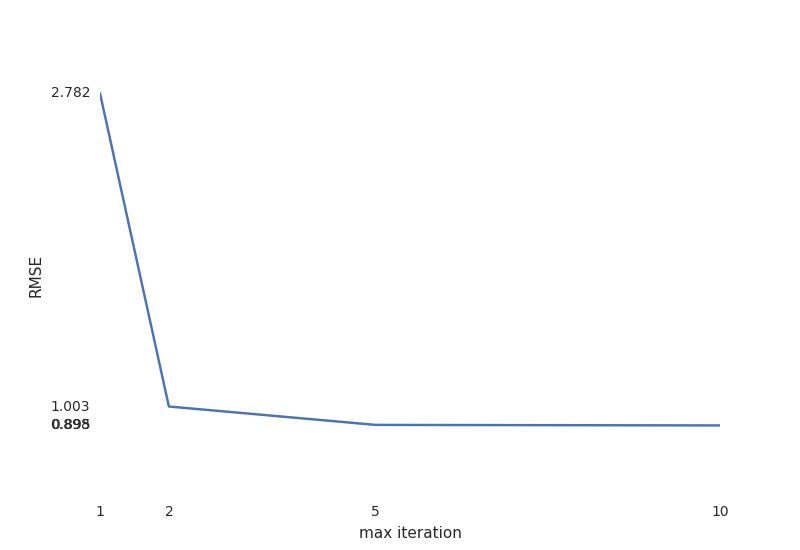

In [43]:
iter_array = [1, 2, 5, 10]
# write your function to plot the learning curve 
y = []
for i in iter_array:
  # fix rank and reg
  als = ALS(rank=14, maxIter=i, regParam=0.2, seed=42, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
  model = als.fit(train)
  # get the RMSE
  predictions = model.transform(validation)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
  error = evaluator.evaluate(predictions)
  y.append(error)
  
fig,ax = plt.subplots(nrows=1)
ax.plot(iter_array, y)
# set ticks and tick labels
ax.set_xticks(iter_array)
ax.set_yticks(y)
ax.set_ylabel("RMSE")
ax.set_xlabel("max iteration")
display(fig)

Usually, we can use elbow point to set hyper parameter efficiently and effectively. Obviously, here, it is a better choice to set max iteration equal to 2 or 5

## Part 3: Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [46]:
predictions = final_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
error = evaluator.evaluate(predictions)
print("Test dataset RMSE = " + str(error))

Test dataset RMSE = 0.8873291848100827